In [1]:
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import ta

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from torch.utils.data import DataLoader,Dataset


DAYS_FOR_TRAIN = 3
FEATURE_SIZE = 10
BATCH_SIZE = 64
TEST_SIZE = 0.3
DROPOUT_PROB = 0

with_sent = True

# selected_ft = [1, 2, 3, 4, 5, 6, 7, 59, 28, 44, 21, 34, 35, 27, 17, 19, 16, 26, 69, 90, 45, 60, 20, 62, 38, 68, 30]
if with_sent:
    selected_ft = [1, 2, 3, 4, 5, 6, 7, 59, 28, 44, 21, 34, 35, 27, 17, 19, 16, 26, 69, 90, 45, 60, 20, 62, 38, 68, 30] # with sent
else:
    selected_ft = [1, 2, 3, 4, 5, 57, 26, 42, 19, 32, 33, 25, 15, 17, 14, 24, 67, 88, 43, 58, 18, 60, 36, 66, 28] 
    
selected_ft = selected_ft[:FEATURE_SIZE]

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
def my_load_data(csv_file):
    ori_data = pd.read_csv(csv_file)
    
    extend_data = ta.add_all_ta_features(ori_data, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
    
    train_data, test_data = train_test_split(extend_data, test_size=TEST_SIZE, shuffle=False)
    return train_data, test_data, ori_data


class StockDataset(Dataset):
    """stock market dataset"""
    
    def __init__(self, dataset, days_for_train=5, feature_size=5, scaled=True, scaler=None):
        self.days_for_train = days_for_train
        self.feature_size = feature_size
        self.ori_data = dataset

        self.data = self.ori_data.iloc[:, selected_ft].values.astype(np.float32)
#         print(self.data)
        if scaled:
            if scaler is None:
                self.scaler = MinMaxScaler()
                self.data = self.scaler.fit_transform(self.data).astype(np.float32)
            else:
                self.data = scaler.transform(self.data).astype(np.float32)
                self.scaler = scaler
        
        self.x = self.data
        self.y = self.data[:, 3]
        
        

    def __len__(self):
        return self.data.shape[0] - self.days_for_train

    
    def __getitem__(self, idx):
        x = self.x[idx:idx+self.days_for_train]
        y = np.zeros((1), dtype=np.float32)

        y[0] = self.y[idx+self.days_for_train]

        t_x = torch.from_numpy(x)
        t_y = torch.from_numpy(y)
        return t_x, t_y
    
    def get_scaler(self):
        return self.scaler


class BaseLSTM_Regression(nn.Module):
    """
        使用LSTM进行回归
        
        参数：
        - input_size: feature size
        - hidden_size: number of hidden units
        - output_size: number of output
        - num_layers: layers of LSTM to stack
    """
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super().__init__()

        self.fc0 = nn.Linear(input_size, input_size)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=DROPOUT_PROB)
        self.fc = nn.Linear(hidden_size, output_size)
        self.fc2 = nn.Linear(DAYS_FOR_TRAIN, output_size)

    def forward(self, _x):
        out0 = self.fc0(_x)
        x, _ = self.lstm(out0)  # _x is input, size (seq_len, batch, input_size)
        s, b, h = x.shape  # x is output, size (seq_len, batch, hidden_size)
        x = x.view(s*b, h)
        out1 = self.fc(x)
        out1 = out1.view(s, b)  # 把形状改回来
        out1 = out1.transpose(0, 1)
#         print('out1', out1.shape)
        out2 = self.fc2(out1)
        # print(out2.shape)
        # out2 = out2.view(b, -1)
        return out2
    

class LSTM_Regression(nn.Module):
    """
        使用LSTM进行回归
        
        参数：
        - input_size: feature size
        - hidden_size: number of hidden units
        - output_size: number of output
        - num_layers: layers of LSTM to stack
    """
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super().__init__()

#         self.fc0 = nn.Linear(input_size, input_size)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=DROPOUT_PROB)
        self.fc = nn.Linear(hidden_size, output_size)
        self.fc2 = nn.Linear(DAYS_FOR_TRAIN, output_size)
#         self.out_fc = nn.Linear()

        self.dropout = nn.Dropout(DROPOUT_PROB)

        
    def attention_net(self, x, query, mask=None):
        d_k = query.size(-1)
        
        scores = torch.matmul(query, x.transpose(1, 2)) / np.sqrt(d_k)
        
        alpha_n = F.softmax(scores, dim=-1)
        
        context = torch.matmul(alpha_n, x).sum(1)
        
        return context, alpha_n
        
        
    def forward(self, _x):
#         out0 = self.fc0(_x)
        x, _ = self.lstm(_x)  # _x is input, size (seq_len, batch, input_size)
#         print(x.shape)
        x = x.permute(1, 0, 2)
#         print(x.shape)
        query = self.dropout(x)
        x, _ = self.attention_net(x, query)
    
#         print(x.shape)
#         s, b, h = x.shape  # x is output, size (seq_len, batch, hidden_size)
        
        
#         x = x.view(s*b, h)
        out1 = self.fc(x)

        return out1
    

class TransReg(nn.Module):
    def __init__(self, input_size, seq_len, batch_size, output_size=1):
        super().__init__()
        
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_size, nhead=input_size)
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=6)
        
        self.fc0 = nn.Linear(input_size, input_size)
        self.fc = nn.Linear(input_size, 1)
        self.fc2 = nn.Linear(seq_len, 1)
        
#         self.
       
    
    
    def forward(self, x):
        s, b, f = x.shape
        
        out = self.encoder(x)
        
        
        x = x.view(s, b, f, 1)
        out = out.view(s, b, f, 1)
        out = torch.cat((x, out), dim=3)
#         print(out.shape)
        out = torch.max(out, 3)[0]
#         print(out.shape)
#         out = np.max(x, out)
        out = out.permute(1, 0, 2)
#         out = out.view(b, s*f)
        out = self.fc0(out)
        out = self.fc(out)
#         print(out.shape)
        out = out.view(b, s)
        out = self.fc2(out)
        
        return out
    

In [4]:
def my_train(train_dataset):
#     print(train_dataset)
    use_gpu = True

    data = StockDataset(train_dataset, DAYS_FOR_TRAIN, FEATURE_SIZE)
    D = DataLoader(dataset=data, batch_size=BATCH_SIZE)

#     model = LSTM_Regression(FEATURE_SIZE, 8, output_size=1, num_layers=2)
    model = TransReg(FEATURE_SIZE, DAYS_FOR_TRAIN, BATCH_SIZE)
#     model.to_de
#     model.train()

    loss_function = nn.MSELoss()
    
#     if use_gpu:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    model.to(device)
    loss_function.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    

    for epoch in range(700):       
        for i, (x, y) in enumerate(D):
#             print(x.shape, y.shape)
            x = x.transpose(0, 1)
            x = x.to(device)
#             x.transpose(1, 2)
            y = y.to(device)
            pred_y = model(x)
#             print('pred_y: ', pred_y.shape)
            loss = loss_function(pred_y, y)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # out = model(train_x)
        # loss = loss_function(out, train_y)

        # loss.backward()
        # optimizer.step()
        # optimizer.zero_grad()

        if (epoch+1) % 20 == 0:
            print('Epoch: {}, Loss:{:.5f}'.format(epoch+1, loss.item()))
    
    return model, data.scaler

In [5]:
def my_test(model, test_dataset, train_scaler, output_file):
    model.eval()
    loss_function = nn.MSELoss()

    test_data = StockDataset(test_dataset, DAYS_FOR_TRAIN, FEATURE_SIZE, True, train_scaler)
    test_D = DataLoader(dataset=test_data, batch_size=1)

    all_rmse = []
    all_mae = []
    preds = []
    targets = []
    
    ori_preds = []
    ori_targets = []
    

    for i, (test_x, test_y) in enumerate(test_D):
        test_x = test_x.transpose(0, 1)
        test_x = test_x.to(device)
        pred_y = model(test_x)
#         print(test_y)
#         print(type(pred_y), type(test_y))
        pred_y = pred_y.cpu()
        tmp_pred_y = pred_y.detach().numpy()[0][0]
        tmp_test_y = test_y.detach().numpy()[0][0]
        
#         print(tmp_pred_y)
        preds.append(tmp_pred_y)
        targets.append(tmp_test_y)
        
        ori_test_y = (tmp_test_y - train_scaler.min_[3]) / train_scaler.scale_[3]
        ori_pred_y = (tmp_pred_y - train_scaler.min_[3]) / train_scaler.scale_[3]
        
        
        ori_preds.append(ori_pred_y)
        ori_targets.append(ori_test_y)

#         rmse = loss_function(test_y, pred_y)
#         all_rmse.append(rmse)
        
#         mae = mean_absolute_error(tmp_test_y, tmp_pred_y)
#         all_mae.append(mae)
    
#         print(test_loss)

    print('mse: %.5f' % (mean_squared_error(targets, preds)))
    print('ori mse: %.5f' % (mean_squared_error(ori_targets, ori_preds)))
    
    print('ori mae: %.5f' % (mean_absolute_error(ori_targets, ori_preds)))
    
#     print('test rmse: %.5f' % (sum(all_rmse)))
#     print('test mae: %.5f' % (sum(all_mae)))
    
    train_size = len(test_data) * (1 - TEST_SIZE)
    plt.plot(preds, 'r', label='prediction')
    plt.plot(targets, 'b', label='real')
    plt.grid()
    plt.legend()
    plt.plot((train_size, train_size), (-0.1, 1.5), 'g--')
    plt.savefig(output_file, format='png', dpi=200)
    plt.show()
    
    return ori_preds, ori_targets

In [6]:
def data2df(ori_preds, ori_targets, ori_dataset):
    out_preds = []
    out_tgts = []
    for i in range(len(ori_preds)):
        out_preds.append(ori_preds[i])
        out_tgts.append(ori_targets[i])

    out_preds_df = pd.DataFrame()
    out_preds_df['Date'] = ori_dataset['Date'][3:].values
    out_preds_df['Close'] = out_preds



    out_tgts_df = pd.DataFrame()
    out_tgts_df['Date'] = ori_dataset['Date'][3:].values
    out_tgts_df['Close'] = out_tgts
    
    return out_preds_df, out_tgts_df

In [7]:
def my_eval(comp, with_sent):
    csv_file = f'data/sentiments/{comp}_sent.csv' if with_sent else f'data/{comp}_ori.csv'
    train_dataset, test_dataset, ori_dataset = my_load_data(csv_file)
    # train_dataset, test_dataset, ori_dataset = my_load_data('data/AAPL.csv')
    trained_model, train_scaler = my_train(train_dataset)

    my_test(trained_model, test_dataset, train_scaler, f'result_img/cur/{comp}_test_result{"_sent" if with_sent else ""}.png')
    ori_preds, ori_targets = my_test(trained_model, ori_dataset, train_scaler, f'result_img/cur/{comp}_result{"_sent" if with_sent else ""}.png')
    
    pred_df, tgt_df = data2df(ori_preds, ori_targets, ori_dataset)
    pred_df.to_csv(f'output/trans_{comp}_pred{"_sent" if with_sent else ""}.csv', index=False)
    tgt_df.to_csv(f'output/trans_{comp}_tgt{"_sent" if with_sent else ""}.csv', index=False)

mse: 0.00228
ori mse: 13.98344
ori mae: 2.95302


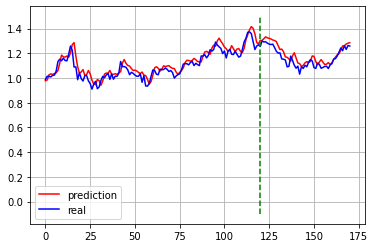

([112.1964,
  112.65273,
  115.94161,
  116.49794,
  116.23777,
  116.641266,
  117.18894,
  118.66422,
  123.338,
  128.42204,
  127.40213,
  127.100784,
  127.85419,
  127.06839,
  129.80783,
  135.1156,
  136.34534,
  127.7803,
  121.05425,
  117.03346,
  117.72453,
  119.25711,
  115.5497,
  116.019554,
  118.67534,
  116.49499,
  112.55356,
  110.046486,
  109.6823,
  112.990456,
  112.24253,
  109.286835,
  111.89494,
  116.42161,
  117.043755,
  116.96817,
  118.70818,
  116.279915,
  116.19908,
  116.637344,
  116.14363,
  117.19214,
  117.91479,
  123.37138,
  125.62448,
  123.22513,
  121.862366,
  121.476746,
  119.9435,
  118.684364,
  118.89001,
  118.37853,
  117.41422,
  116.76013,
  117.6701,
  115.682076,
  115.45571,
  113.057556,
  110.03205,
  111.64817,
  115.66311,
  120.3969,
  121.03789,
  120.10676,
  118.29579,
  119.47716,
  121.60359,
  121.1785,
  121.516685,
  121.746544,
  120.62996,
  120.02052,
  119.91947,
  117.67671,
  116.20455,
  117.466156,
  118.

In [54]:
my_test(trained_model, test_dataset, train_scaler, f'result_img/cur/{comp}_test_result{"_sent" if with_sent else ""}.png')

In [12]:
comp = 'aapl'

csv_file = f'data/sentiments/{comp}_sent.csv' if with_sent else f'data/{comp}_ori.csv'
train_dataset, test_dataset, ori_dataset = my_load_data(csv_file)

C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


In [14]:
res = ori_dataset.iloc[:, selected_ft]
res

,Open,High,Low,Close,Adj Close,Volume,Pos,trend_kst_diff,volatility_kch,trend_sma_slow
0,38.722500,39.712502,38.557499,39.480000,38.505024,148158800,0.546218,0.000000,40.405003,39.480000
1,35.994999,36.430000,35.500000,35.547501,34.669640,365248800,0.563916,-12.129311,38.580419,37.513751
2,36.132500,37.137501,35.950001,37.064999,36.149662,234428400,0.570658,-9.316535,38.355279,37.364167
3,37.174999,37.207500,36.474998,36.982498,36.069202,219111200,0.594595,-7.870309,38.171668,37.268749
4,37.389999,37.955002,37.130001,37.687500,36.756794,164101200,0.591705,-5.469633,38.220501,37.352500
...,...,...,...,...,...,...,...,...,...,...
577,133.509995,135.470001,133.339996,134.839996,134.839996,94264200,0.400000,42.773578,133.888999,125.950000
578,135.020004,135.529999,131.809998,133.110001,133.110001,94812300,0.600000,40.770863,134.828333,126.414615
579,132.360001,133.750000,131.300003,133.500000,133.500000,68847100,0.400000,38.828515,135.381667,126.780384
580,133.039993,134.149994,131.410004,131.940002,131.940002,84566500,0.600000,34.086127,135.742999,127.025384


## Evaluation

C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


cuda:0
Epoch: 20, Loss:0.06657
Epoch: 40, Loss:0.01439
Epoch: 60, Loss:0.00650
Epoch: 80, Loss:0.00516
Epoch: 100, Loss:0.00614
Epoch: 120, Loss:0.00563
Epoch: 140, Loss:0.00559
Epoch: 160, Loss:0.00539
Epoch: 180, Loss:0.00534
Epoch: 200, Loss:0.00529
Epoch: 220, Loss:0.00550
Epoch: 240, Loss:0.00522
Epoch: 260, Loss:0.00528
Epoch: 280, Loss:0.00544
Epoch: 300, Loss:0.00528
Epoch: 320, Loss:0.00517
Epoch: 340, Loss:0.00512
Epoch: 360, Loss:0.00513
Epoch: 380, Loss:0.00495
Epoch: 400, Loss:0.00495
Epoch: 420, Loss:0.00493
Epoch: 440, Loss:0.00456
Epoch: 460, Loss:0.00439
Epoch: 480, Loss:0.00441
Epoch: 500, Loss:0.00446
Epoch: 520, Loss:0.00430
Epoch: 540, Loss:0.00441
Epoch: 560, Loss:0.00449
Epoch: 580, Loss:0.00425
Epoch: 600, Loss:0.00432
Epoch: 620, Loss:0.00414
Epoch: 640, Loss:0.00388
Epoch: 660, Loss:0.00387
Epoch: 680, Loss:0.00372
Epoch: 700, Loss:0.00396
mse: 0.00991
ori mse: 60.83081
ori mae: 6.67131


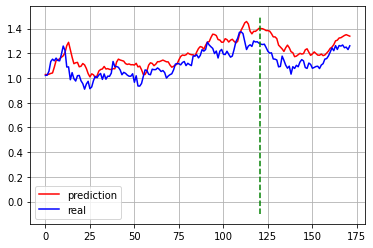

mse: 0.00347
ori mse: 21.32219
ori mae: 2.99167


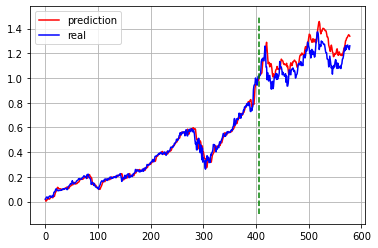

In [9]:
my_eval('aapl', with_sent)

C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


cuda:0
Epoch: 20, Loss:0.12133
Epoch: 40, Loss:0.00200
Epoch: 60, Loss:0.00198
Epoch: 80, Loss:0.00196
Epoch: 100, Loss:0.00173
Epoch: 120, Loss:0.00167
Epoch: 140, Loss:0.00158
Epoch: 160, Loss:0.00157
Epoch: 180, Loss:0.00211
Epoch: 200, Loss:0.00169
Epoch: 220, Loss:0.00159
Epoch: 240, Loss:0.00181
Epoch: 260, Loss:0.00151
Epoch: 280, Loss:0.00234
Epoch: 300, Loss:0.00189
Epoch: 320, Loss:0.00193
Epoch: 340, Loss:0.00177
Epoch: 360, Loss:0.00186
Epoch: 380, Loss:0.00184
Epoch: 400, Loss:0.00177
Epoch: 420, Loss:0.00187
Epoch: 440, Loss:0.00178
Epoch: 460, Loss:0.00182
Epoch: 480, Loss:0.00166
Epoch: 500, Loss:0.00169
Epoch: 520, Loss:0.00191
Epoch: 540, Loss:0.00179
Epoch: 560, Loss:0.00148
Epoch: 580, Loss:0.00173
Epoch: 600, Loss:0.00167
Epoch: 620, Loss:0.00175
Epoch: 640, Loss:0.00132
Epoch: 660, Loss:0.00172
Epoch: 680, Loss:0.00124
Epoch: 700, Loss:0.00113
mse: 0.00210
ori mse: 6254.01660
ori mae: 62.34291


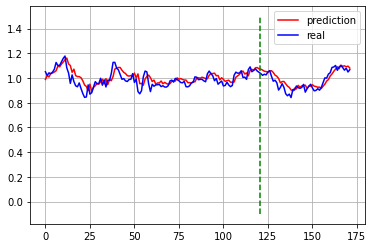

mse: 0.00096
ori mse: 2857.17188
ori mae: 37.66051


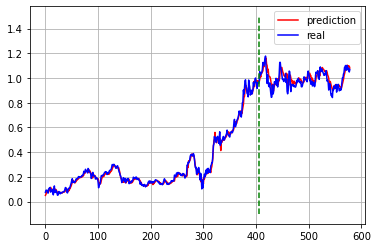

In [10]:
my_eval('amzn', with_sent)

C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


cuda:0
Epoch: 20, Loss:0.00271
Epoch: 40, Loss:0.00251
Epoch: 60, Loss:0.00168
Epoch: 80, Loss:0.00162
Epoch: 100, Loss:0.00205
Epoch: 120, Loss:0.00195
Epoch: 140, Loss:0.00204
Epoch: 160, Loss:0.00190
Epoch: 180, Loss:0.00176
Epoch: 200, Loss:0.00171
Epoch: 220, Loss:0.00166
Epoch: 240, Loss:0.00190
Epoch: 260, Loss:0.00169
Epoch: 280, Loss:0.00186
Epoch: 300, Loss:0.00163
Epoch: 320, Loss:0.00182
Epoch: 340, Loss:0.00193
Epoch: 360, Loss:0.00187
Epoch: 380, Loss:0.00190
Epoch: 400, Loss:0.00187
Epoch: 420, Loss:0.00164
Epoch: 440, Loss:0.00203
Epoch: 460, Loss:0.00188
Epoch: 480, Loss:0.00182
Epoch: 500, Loss:0.00169
Epoch: 520, Loss:0.00164
Epoch: 540, Loss:0.00166
Epoch: 560, Loss:0.00164
Epoch: 580, Loss:0.00161
Epoch: 600, Loss:0.00166
Epoch: 620, Loss:0.00167
Epoch: 640, Loss:0.00165
Epoch: 660, Loss:0.00167
Epoch: 680, Loss:0.00164
Epoch: 700, Loss:0.00163
mse: 0.00916
ori mse: 2796.12061
ori mae: 40.94781


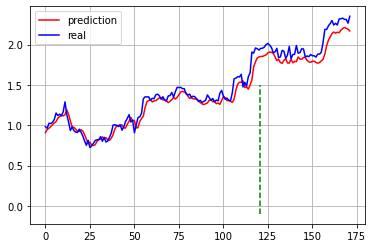

mse: 0.00411
ori mse: 1253.66272
ori mae: 24.15161


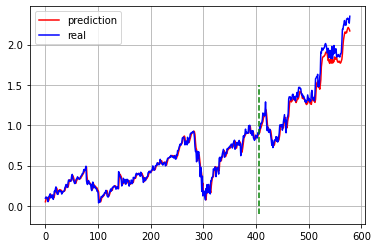

In [8]:
my_eval('goog', with_sent)

C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


cuda:0
Epoch: 20, Loss:0.14092
Epoch: 40, Loss:0.01048
Epoch: 60, Loss:0.00358
Epoch: 80, Loss:0.00217
Epoch: 100, Loss:0.00237
Epoch: 120, Loss:0.00179
Epoch: 140, Loss:0.00159
Epoch: 160, Loss:0.00161
Epoch: 180, Loss:0.00143
Epoch: 200, Loss:0.00182
Epoch: 220, Loss:0.00171
Epoch: 240, Loss:0.00168
Epoch: 260, Loss:0.00170
Epoch: 280, Loss:0.00162
Epoch: 300, Loss:0.00201
Epoch: 320, Loss:0.00185
Epoch: 340, Loss:0.00172
Epoch: 360, Loss:0.00174
Epoch: 380, Loss:0.00169
Epoch: 400, Loss:0.00167
Epoch: 420, Loss:0.00174
Epoch: 440, Loss:0.00174
Epoch: 460, Loss:0.00168
Epoch: 480, Loss:0.00160
Epoch: 500, Loss:0.00159
Epoch: 520, Loss:0.00170
Epoch: 540, Loss:0.00174
Epoch: 560, Loss:0.00168
Epoch: 580, Loss:0.00167
Epoch: 600, Loss:0.00212
Epoch: 620, Loss:0.00169
Epoch: 640, Loss:0.00174
Epoch: 660, Loss:0.00169
Epoch: 680, Loss:0.00177
Epoch: 700, Loss:0.00174
mse: 0.00235
ori mse: 33.34090
ori mae: 4.61386


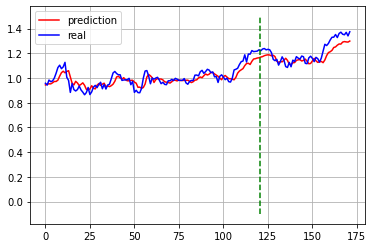

mse: 0.00118
ori mse: 16.81165
ori mae: 2.90288


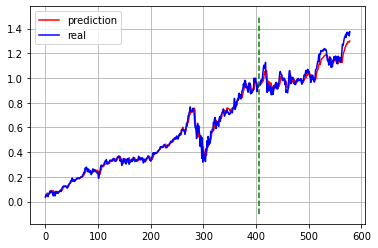

In [9]:
my_eval('msft', with_sent)

C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


cuda:0
Epoch: 20, Loss:0.01728
Epoch: 40, Loss:0.00220
Epoch: 60, Loss:0.00242
Epoch: 80, Loss:0.00222
Epoch: 100, Loss:0.00182
Epoch: 120, Loss:0.00160
Epoch: 140, Loss:0.00209
Epoch: 160, Loss:0.00146
Epoch: 180, Loss:0.00207
Epoch: 200, Loss:0.00187
Epoch: 220, Loss:0.00138
Epoch: 240, Loss:0.00144
Epoch: 260, Loss:0.00157
Epoch: 280, Loss:0.00124
Epoch: 300, Loss:0.00123
Epoch: 320, Loss:0.00092
Epoch: 340, Loss:0.00133
Epoch: 360, Loss:0.00102
Epoch: 380, Loss:0.00152
Epoch: 400, Loss:0.00132
Epoch: 420, Loss:0.00111
Epoch: 440, Loss:0.00101
Epoch: 460, Loss:0.00188
Epoch: 480, Loss:0.00118
Epoch: 500, Loss:0.00097
Epoch: 520, Loss:0.00101
Epoch: 540, Loss:0.00128
Epoch: 560, Loss:0.00112
Epoch: 580, Loss:0.00086
Epoch: 600, Loss:0.00108
Epoch: 620, Loss:0.00103
Epoch: 640, Loss:0.00095
Epoch: 660, Loss:0.00112
Epoch: 680, Loss:0.00091
Epoch: 700, Loss:0.00085
mse: 0.00340
ori mse: 294.41074
ori mae: 12.43617


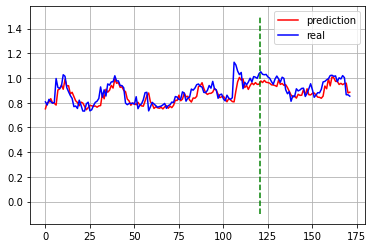

mse: 0.00149
ori mse: 128.81032
ori mae: 7.79378


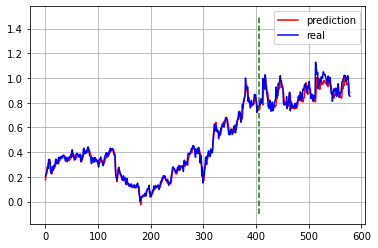

In [10]:
my_eval('nflx', with_sent)

C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


cuda:0
Epoch: 20, Loss:0.15779
Epoch: 40, Loss:0.01880
Epoch: 60, Loss:0.00311
Epoch: 80, Loss:0.00356
Epoch: 100, Loss:0.00323
Epoch: 120, Loss:0.00313
Epoch: 140, Loss:0.00299
Epoch: 160, Loss:0.00283
Epoch: 180, Loss:0.00335
Epoch: 200, Loss:0.00304
Epoch: 220, Loss:0.00267
Epoch: 240, Loss:0.00260
Epoch: 260, Loss:0.00284
Epoch: 280, Loss:0.00271
Epoch: 300, Loss:0.00243
Epoch: 320, Loss:0.00237
Epoch: 340, Loss:0.00236
Epoch: 360, Loss:0.00228
Epoch: 380, Loss:0.00250
Epoch: 400, Loss:0.00221
Epoch: 420, Loss:0.00229
Epoch: 440, Loss:0.00223
Epoch: 460, Loss:0.00228
Epoch: 480, Loss:0.00229
Epoch: 500, Loss:0.00228
Epoch: 520, Loss:0.00224
Epoch: 540, Loss:0.00232
Epoch: 560, Loss:0.00196
Epoch: 580, Loss:0.00218
Epoch: 600, Loss:0.00233
Epoch: 620, Loss:0.00230
Epoch: 640, Loss:0.00214
Epoch: 660, Loss:0.00221
Epoch: 680, Loss:0.00229
Epoch: 700, Loss:0.00218
mse: 0.01933
ori mse: 1657.51611
ori mae: 30.73520


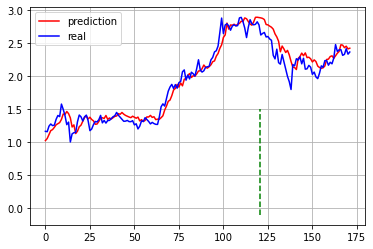

mse: 0.00647
ori mse: 554.34106
ori mae: 13.10643


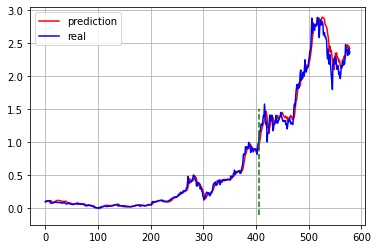

In [14]:
my_eval('tsla', with_sent)

aapl
cuda:0


C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


Epoch: 20, Loss:0.03520
Epoch: 40, Loss:0.03018
Epoch: 60, Loss:0.01342
Epoch: 80, Loss:0.00825
Epoch: 100, Loss:0.00529
Epoch: 120, Loss:0.00483
Epoch: 140, Loss:0.00470
Epoch: 160, Loss:0.00480
Epoch: 180, Loss:0.00458
Epoch: 200, Loss:0.00445
Epoch: 220, Loss:0.00412
Epoch: 240, Loss:0.00437
Epoch: 260, Loss:0.00356
Epoch: 280, Loss:0.00329
Epoch: 300, Loss:0.00294
Epoch: 320, Loss:0.00297
Epoch: 340, Loss:0.00309
Epoch: 360, Loss:0.00307
Epoch: 380, Loss:0.00311
Epoch: 400, Loss:0.00239
Epoch: 420, Loss:0.00218
Epoch: 440, Loss:0.00282
Epoch: 460, Loss:0.00232
Epoch: 480, Loss:0.00191
Epoch: 500, Loss:0.00213
Epoch: 520, Loss:0.00184
Epoch: 540, Loss:0.00207
Epoch: 560, Loss:0.00191
Epoch: 580, Loss:0.00181
Epoch: 600, Loss:0.00191
Epoch: 620, Loss:0.00193
Epoch: 640, Loss:0.00242
Epoch: 660, Loss:0.00169
Epoch: 680, Loss:0.00202
Epoch: 700, Loss:0.00187
mse: 0.00827
ori mse: 50.75599
ori mae: 6.11419


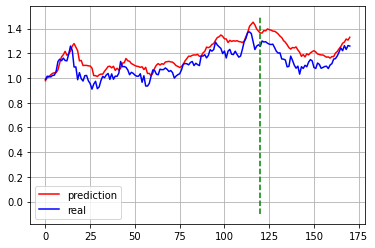

mse: 0.00272
ori mse: 16.72226
ori mae: 2.52956


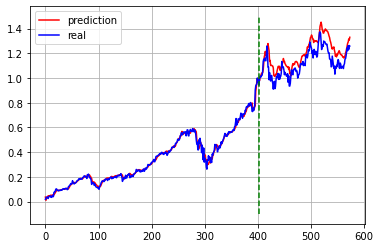

amzn
cuda:0


C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


Epoch: 20, Loss:0.19137
Epoch: 40, Loss:0.02603
Epoch: 60, Loss:0.00228
Epoch: 80, Loss:0.00238


KeyboardInterrupt: 

In [62]:
comps = ['aapl', 'amzn', 'goog', 'msft', 'nflx', 'tsla']

for comp in comps:
    print(comp)
    my_eval(comp, with_sent)

## try xgboost to select features

In [15]:
import xgboost as xgb
import numpy as np
import pandas as pd
import ta
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

TEST_SIZE = 0.3

def xgb_load_data(csv_file):
    ori_data = pd.read_csv(csv_file)
    
    extend_data = ta.add_all_ta_features(ori_data, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
    
    train_data, test_data = train_test_split(ori_data, test_size=TEST_SIZE, shuffle=False)
    return train_data, test_data, ori_data


train_data, test_data, ori_data = xgb_load_data('data/AAPL.csv')

train_data = train_data.iloc[:, 1:]
train_x = train_data.iloc[:-1, 1:]
train_y = train_data.iloc[1:, 4].values

test_data = test_data.iloc[:, 1:]
test_x = test_data.iloc[:-1, 1:]
test_y = test_data.iloc[1:, 4].values

/Users/liu/dsci_560_project/myenv/lib/python3.8/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/Users/liu/dsci_560_project/myenv/lib/python3.8/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


In [20]:
data_dmatrix = xgb.DMatrix(data=train_x.values,label=train_y)
test_dmatrix = xgb.DMatrix(data=test_x.values,label=test_y)

rses = []
# for i in range(10):
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
            'max_depth': 6, 'alpha': 11, 'tree_method': 'hist', 'lambda': 0.1} 
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=50, evals=[(test_dmatrix, 'errors')])
te_preds = xg_reg.predict(test_dmatrix)
rmse = np.sqrt(mean_squared_error(test_y, te_preds))
print('rmse: ', rmse)
#     rses.append((pt, rmse))
#     print(i, rmse)

[20:32:52] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[0]	errors-rmse:113.01026
[1]	errors-rmse:104.49601
[2]	errors-rmse:96.74514
[3]	errors-rmse:89.93866
[4]	errors-rmse:83.43624
[5]	errors-rmse:77.58589
[6]	errors-rmse:72.59512
[7]	errors-rmse:66.93047
[8]	errors-rmse:61.83071
[9]	errors-rmse:57.24035
[10]	errors-rmse:53.82044
[11]	errors-rmse:50.03221
[12]	errors-rmse:47.02351
[13]	errors-rmse:44.61453
[14]	errors-rmse:41.83351
[15]	errors-rmse:39.64758
[16]	errors-rmse:37.89893
[17]	errors-rmse:35.71607
[18]	errors-rmse:34.17898
[19]	errors-rmse:32.62237
[20]	errors-rmse:31.00129
[21]	errors-rmse:29.75846
[22]	errors-rmse:28.84347
[23]	errors-rmse:27.81024
[24]	errors-rmse:27.08557
[25]	errors-rmse:26.03073
[26]	errors-rmse:25.52164
[27]	errors-rmse:24.98928
[28]	errors-rmse:24.14652
[29]	errors-rmse:24.00672
[30]	errors-rmse:23.32227
[31]	errors-rmse:22.83166
[32]	errors-rmse:22.27708
[

In [26]:
importances = xg_reg.get_score(importance_type='gain')
res = sorted(importances.items(), key=lambda x: -x[1])
res

[('f56', 11905.57040405),
 ('f25', 11737.658460617075),
 ('f0', 8419.552833158667),
 ('f41', 4560.65625),
 ('f3', 3942.2264994197094),
 ('f18', 3173.453125),
 ('f1', 2523.9542467499996),
 ('f31', 1680.225341797),
 ('f32', 1677.2402850985),
 ('f24', 1247.86335563),
 ('f14', 1213.2620371102),
 ('f16', 767.6363924000001),
 ('f13', 728.6583794213999),
 ('f23', 661.4594890025716),
 ('f2', 556.6516581407724),
 ('f66', 307.598145),
 ('f5', 243.39853353891664),
 ('f87', 205.029135086),
 ('f42', 180.27246095),
 ('f57', 76.9911499),
 ('f17', 64.1914062),
 ('f59', 39.22134396166667),
 ('f35', 30.613647484999998),
 ('f65', 24.076538096666667),
 ('f27', 14.2793665),
 ('f51', 12.856872535),
 ('f44', 11.252526250499999),
 ('f30', 9.0066628385),
 ('f43', 6.817631416299999),
 ('f50', 6.76679612),
 ('f8', 6.74428557735),
 ('f78', 6.68048096),
 ('f7', 6.196217864666667),
 ('f69', 5.377791885375),
 ('f46', 5.205932623333333),
 ('f63', 5.142871976),
 ('f74', 4.659321122000001),
 ('f19', 4.3507461549999995)

In [30]:
features = [int(item[0][1:])+1 for item in res[:25]]
print(features)

[57, 26, 1, 42, 4, 19, 2, 32, 33, 25, 15, 17, 14, 24, 3, 67, 6, 88, 43, 58, 18, 60, 36, 66, 28]
